# Sequential Transition Analysis
The following notebook uses first order markovian rules to determine the observed forward transition probabilities for segments within calls, depending on the immediately preceding segment. 

See [Sainburg et al., (2020)](https://doi.org/10.1371/journal.pcbi.1008228) and [github.com/timsainb/avgn](https://github.com/timsainb/avgn_paper) for further detail on the source code (modified here) used for the production of these figures. 

This notebook uses Python v3.8.13 (compared to v3.6 used in earlier notebooks).

In [1]:
from tqdm.auto import tqdm

In [2]:
import avgn

In [3]:
import pandas as pd
import numpy as np
from avgn.utils.paths import DATA_DIR, ensure_dir, FIGURE_DIR

In [4]:
DATASET_ID = "git_repos"

In [5]:
DT_ID = '2022-03-04_18-41-29'

In [6]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'segment_df_umap_combinedtidied.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[14.15081, 3.406464]",DS,DS-SH-DS,DS-SH-DS SH-LH
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.388335, 10.057652]",SH,DS-SH-DS,DS-SH-DS SH-LH
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[12.421062, 0.6991728]",DS,DS-SH-DS,DS-SH-DS SH-LH


### Plot barcodes for organization

In [7]:
import matplotlib.pyplot as plt
from avgn.visualization.barcodes_magpie import plot_sorted_barcodes, indv_barcode

In [8]:
seg_df.sort_values(by=['comb_labels'], inplace = True)

comb_labels ['DS' 'LH' 'NL' 'SH']


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/8778 [00:00<?, ?it/s]

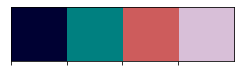

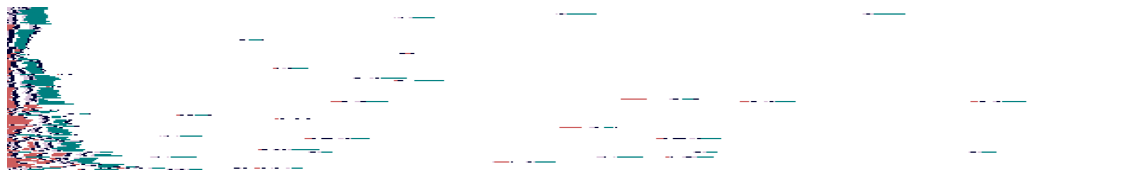

In [9]:
color = ['xkcd:very dark blue','teal','indianred', 'thistle']

all_dict = {}
for label in ["comb_labels"]:
    print(label, seg_df[label].unique())
    color_lists, trans_lists, label_pal_dict, label_pal, label_dict = indv_barcode(
        seg_df,
        time_resolution=0.03,
        label="comb_labels",
        pal=color,
    )
    
    all_dict[label] = {
    "label_pal_dict": label_pal_dict,
    "label_dict": label_dict,
    }
    
    fig, ax = plt.subplots(figsize=(20, 3))

    plot_sorted_barcodes(
        color_lists,
        trans_lists,
        max_list_len=600,
        seq_len=100,
        nex=200,
        figsize=(10, 4),
        ax=ax,
    )
    plt.show()


In [10]:
seg_df.sort_values(by=['ID'], inplace = True)

In [8]:
from avgn.visualization.projections_magpie import scatter_spec
from avgn.utils.general import save_fig

In [12]:
import seaborn as sns

### Combine UMAP & Transition Graph
- this plot shows the segment UMAP as well as the transition graph using Markov modelling

In [9]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [10]:
specs = list(seg_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]

  0%|          | 0/1333 [00:00<?, ?it/s]

In [18]:
from avgn.visualization.network_graph_magpie import plot_network_graph

In [13]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(24)
ax1 = plt.subplot2grid(shape=(1, 24), loc=(0, 0), colspan=12)  ##1st Row
ax2 = plt.subplot2grid(shape=(1, 24), loc=(0, 12), colspan=12) #2nd row


color = ['xkcd:very dark blue','teal','indianred', 'thistle']

nex = -1
ax1.axis('off')
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=10,
    x_range = [-2.25,15.5],
    y_range = [-4.5, 12.25],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    ax = ax1,
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.comb_labels.values,
        'alpha':1,
        's': 5,
        'show_legend': False,
        "color_palette": color,
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.5,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3, 

)

##Model
for label in ["comb_labels"]:
    print(label)
    # plot graph
    elements = seg_df[label].values
    projections = np.array(list(seg_df['umap'].values))
    sequence_ids = np.array(seg_df["call_unique_num"])

    label_pal_dict = all_dict[label]['label_pal_dict']
    label_dict = all_dict[label]['label_dict']
    pal_dict = {i:label_pal_dict[j] for i,j in label_dict.items()}
    ax2.axis('off')
    plot_network_graph(
        elements, projections, sequence_ids, ax=ax2, pal_dict=pal_dict
    )

ax1.set_title("A)", loc='left', fontsize = 30)
ax2.set_title("B)", loc='left', fontsize = 30)
legend = ax2.legend(loc='upper left', labels = label_dict, fontsize=25)
handles = legend.legendHandles
#Create legend
#colors = ['xkcd:very dark blue','xkcd:twilight blue','xkcd:water blue', 'xkcd:powder blue']
for i, handle in enumerate(handles):
    handle.set_edgecolor(color[i]) # set_edgecolors
    handle.set_facecolor(color[i])
    #handle.set_alpha(0.7)

plt.tight_layout()
save_loc = (FIGURE_DIR / DATASET_ID / 'Figures' / 'Transition & UMAP' / 'Fig2b_coloursnew.jpeg')
ensure_dir(save_loc.as_posix())
save_fig(save_loc, dpi=600, save_jpg=True)
plt.show()
